# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

In [30]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):

    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)

    # NNaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    # 한국어 토크나이저로 토큰화, 불용어(Stopwords) 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    # 사전word_to_index 구성
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
  
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [31]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [32]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포

In [33]:
len(max(X_train, key=len))

116

In [34]:
len(max(X_test, key=len))

105

* 적절한 최대 문장 길이 지정

In [35]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [36]:
maxlen = 60
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < maxlen) / len(num_tokens)))

pad_sequences maxlen :  60
전체 문장의 0.9859833417801873%가 maxlen 설정값 이내에 포함됩니다. 


* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [37]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 60)


## 4) 모델구성 및 validation set 구성

In [40]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 128로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,118,289
Trainable params: 1,118,289
Non-trainable params: 0
_________________________________________________________________


In [41]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 60)
(136182,)


## 5) 모델 훈련 개시

In [47]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 6s 19ms/step - loss: 0.0114 - accuracy: 0.9960 - val_loss: 0.9736 - val_accuracy: 0.8277
Epoch 2/20
266/266 [==============================] - 5s 18ms/step - loss: 0.0090 - accuracy: 0.9968 - val_loss: 0.9969 - val_accuracy: 0.8273
Epoch 3/20
266/266 [==============================] - 5s 18ms/step - loss: 0.0090 - accuracy: 0.9963 - val_loss: 1.0317 - val_accuracy: 0.8270
Epoch 4/20
266/266 [==============================] - 5s 18ms/step - loss: 0.0076 - accuracy: 0.9966 - val_loss: 1.0640 - val_accuracy: 0.8255
Epoch 5/20
266/266 [==============================] - 5s 18ms/step - loss: 0.0069 - accuracy: 0.9969 - val_loss: 1.0772 - val_accuracy: 0.8271
Epoch 6/20
266/266 [==============================] - 5s 18ms/step - loss: 0.0075 - accuracy: 0.9968 - val_loss: 1.1085 - val_accuracy: 0.8269
Epoch 7/20
266/266 [==============================] - 5s 18ms/step - loss: 0.0061 - accuracy: 0.9970 - val_loss: 1.1442 - val_accuracy: 0.8251

In [48]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.4068 - accuracy: 0.8228
[1.4067509174346924, 0.8228126168251038]


### 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [43]:
model = keras.Sequential(name="GlobalMaxPooling1D")

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "GlobalMaxPooling1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 6s 19ms/step - loss: 0.5749 - accuracy: 0.7611 - val_loss: 0.3444 - val_accuracy: 0.8476
Epoch 2/20
266/266 [==============================] - 5s 18ms/step - loss: 0.3163 - accuracy: 0.8674 - val_loss: 0.3282 - val_accuracy: 0.8535
Epoch 3/20
266/266 [==============================] - 5s 18ms/step - loss: 0.2691 - accuracy: 0.8915 - val_loss: 0.3321 - val_accuracy: 0.8562
Epoch 4/20
266/266 [==============================] - 5s 18ms/step - loss: 0.2369 - accuracy: 0.9078 - val_loss: 0.3405 - val_accuracy: 0.8534
Epoch 5/20
266/266 [==============================] - 5s 18ms/step - loss: 0.2030 - accuracy: 0.9227 - val_loss: 0.3554 - val_accuracy: 0.8543
Epoch 6/20
266/266 [==============================] - 5s 18ms/step - loss: 0.1709 - accuracy: 0.9390 - val_loss: 0.3778 - val_accuracy: 0.8517
Epoch 7/20
266/266 [==============================] - 5s 18ms/step - loss: 0.1404 - accuracy: 0.9537 - val_loss: 0.4046 - val_accuracy: 0.8511

In [46]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8721 - accuracy: 0.8300
[0.8720548152923584, 0.8299936652183533]


In [49]:
model = keras.Sequential(name="CNN")
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9       

In [50]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 15s 41ms/step - loss: 0.6155 - accuracy: 0.6346 - val_loss: 0.4566 - val_accuracy: 0.7686
Epoch 2/20
266/266 [==============================] - 6s 23ms/step - loss: 0.4227 - accuracy: 0.7935 - val_loss: 0.4480 - val_accuracy: 0.7742
Epoch 3/20
266/266 [==============================] - 6s 22ms/step - loss: 0.3710 - accuracy: 0.8215 - val_loss: 0.4556 - val_accuracy: 0.7723
Epoch 4/20
266/266 [==============================] - 6s 22ms/step - loss: 0.3082 - accuracy: 0.8545 - val_loss: 0.4855 - val_accuracy: 0.7703
Epoch 5/20
266/266 [==============================] - 6s 23ms/step - loss: 0.2458 - accuracy: 0.8859 - val_loss: 0.5530 - val_accuracy: 0.7592
Epoch 6/20
266/266 [==============================] - 6s 22ms/step - loss: 0.1980 - accuracy: 0.9054 - val_loss: 0.6335 - val_accuracy: 0.7501
Epoch 7/20
266/266 [==============================] - 6s 23ms/step - loss: 0.1693 - accuracy: 0.9142 - val_loss: 0.7141 - val_accuracy: 0.747

In [51]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 1.4816 - accuracy: 0.7467
[1.481640100479126, 0.7467095255851746]


## 6) Loss, Accuracy 그래프 시각화

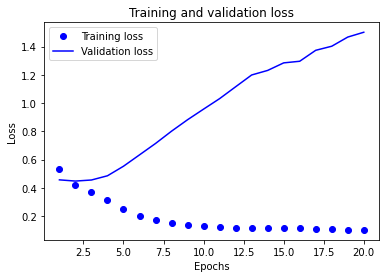

In [53]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

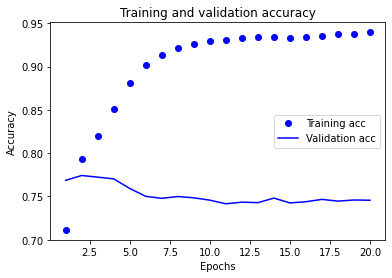

In [54]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [55]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [56]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [59]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.00029031,  0.05046954,  0.04061382, -0.05613692,  0.03706778,
        0.00553889, -0.03591449,  0.04180273,  0.05565188, -0.10885328,
       -0.01883481, -0.100069  , -0.0321345 , -0.07206215,  0.1872433 ,
       -0.04890811,  0.01252674, -0.07293187,  0.16837628, -0.0830813 ,
        0.04636694,  0.09115018, -0.11808152, -0.06413104, -0.0353529 ,
        0.02874046,  0.20507602, -0.03578813, -0.14719257,  0.02711112,
       -0.02451355,  0.14338693, -0.06511319,  0.0262769 ,  0.02507361,
       -0.06549697, -0.03236672,  0.12715873, -0.07297161,  0.08171759,
        0.10524162, -0.12295517,  0.10595667,  0.01000145,  0.00668571,
       -0.02400471, -0.04482238,  0.00353443,  0.06502837,  0.03967701,
        0.15089194,  0.00239917, -0.09810237, -0.09678426, -0.09134007,
       -0.12316646,  0.02830409, -0.07161871,  0.11015457, -0.01201164,
        0.05824914,  0.04525292, -0.00544359,  0.12377141, -0.18094036,
        0.05730632, -0.1355027 ,  0.1102135 ,  0.04720941, -0.07

In [60]:
word_vectors.similar_by_word("사랑")

[('맞춰', 0.5889158844947815),
 ('오스카', 0.5815695524215698),
 ('수작', 0.5683230757713318),
 ('♥♥♥♥', 0.5587139129638672),
 ('흐뭇', 0.5416143536567688),
 ('지니', 0.5404002070426941),
 ('퍼지', 0.5373687148094177),
 ('최고', 0.5313001275062561),
 ('케이온', 0.5271182656288147),
 ('하루하루', 0.5210147500038147)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

### 한국어 Word2Vec 다운로드 받으려고 하니 액세스 권한 필요하다고 나옵니다. 권한 요청 보냈는데 당장 허가 이메일이 오지를 않네요. 오늘은 여기까지가 끝인가 봅니다.

# 후기

### 코로나19 백신을 맞은 날, 아니 그 다음 날의 3시 30분(15시 30분 아님 주의), 나는 왜 새벽까지 이러고 있는가? 모두 나의 게으름과 부덕의 소치이겠지라고 하기엔 요즘 꽤나 빡세게 살고 있다. 새벽까지 이러고 있는 거라면 제출 기한을 못 맞춘 거라서 혹시 감점이라도 당하는 것일까? 사실 별점은 내려놓았으니까 큰 상관 없다. 백신 맞은 날은 잘 쉬라고 문자 메시지가 왔던데 설마 내일부터 몸져 눕는 건 아니겠지.

### 왜 한국어 벡터 데이터는 다운로드 제한이 걸려있는 것일까? 다른 사람들은 별 문제 없었던 모양인데 지금 새벽에야 제한이 걸린 것일까? 생각해 보니 이건 분명 그만하고 쉬라는 하늘의 뜻이다.

### 그럴듯한 결과물을 만들어내는 거 같지만 과연 나는 이 과제를 통하여 무엇을 배운 것일까? 투자한 시간만큼, 그만큼 배우고 얻어간 것일까? 결코 아니다. 제대로 배우면서 하기에는 시간이 너무 많이 걸린다. 내가 지금 하는 방식은 그저 복사, 붙여넣기의 향연에 가깝다. 시간만 좀 들일 수 있다면, 천천히 천천히 할 수 있다면 훨씬 많은 걸 배울 수 있을 텐데... 내가 지금 추구하는 것은 완벽주의가 아니다. 적절한 시간 투자로 적절한 만큼 배우고 싶을 뿐이다. 보다 준비된 다른 사람들은 잘 따라갈 수 있겠지만, 이와 같은 수박 겉핥기 식의 현실은 나에게는 나아갈 길이 아닌 것 같다.

### 잎새에 이는 바람에도 나는 괴로워 하고 오늘밤에도 별이 바람에 스치운다.